[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/usnistgov/AFL-agent/blob/main/docs/source/tutorials/autosas_tutorial.ipynb)

# Do Model Selection with AutoSAS


## Google Colab Setup

Only uncomment and run the next cell if you are running this notebook in Google Colab or if don't already have the AFL-agent package installed.

In [ ]:
# !pip install git+https://github.com/usnistgov/AFL-agent.git

## Getting Started

First, let's import the necessary packages and load our example dataset:

In [1]:
import matplotlib.pyplot as plt

from AFL.double_agent import *
from AFL.double_agent.AutoSAS import AutoSAS


Next, let's load the example dataset. We'll subselect only part of the dataset to work with

In [2]:
from AFL.double_agent.data import example_dataset2

# Load example dataset and select the mass_fractal model
ds = example_dataset2()
ds = ds.where(ds.model.isin(['surface_fractal','mass_fractal','polymer_excl_volume']),drop=True)
ds

<xarray.Dataset> Size: 49kB
Dimensions:  (sample: 30, q: 100)
Coordinates:
  * q        (q) float64 800B 0.001 0.001072 0.00115 ... 0.8697 0.9326 1.0
Dimensions without coordinates: sample
Data variables:
    I        (sample, q) float64 24kB 5.465e+03 4.598e+03 ... 1.1 1.002
    dI       (sample, q) float64 24kB 545.9 429.3 342.6 ... 0.09923 0.09923
    model    (sample) object 240B 'surface_fractal' ... 'mass_fractal'

Let's plot the data so we can see what we're trying to fit.

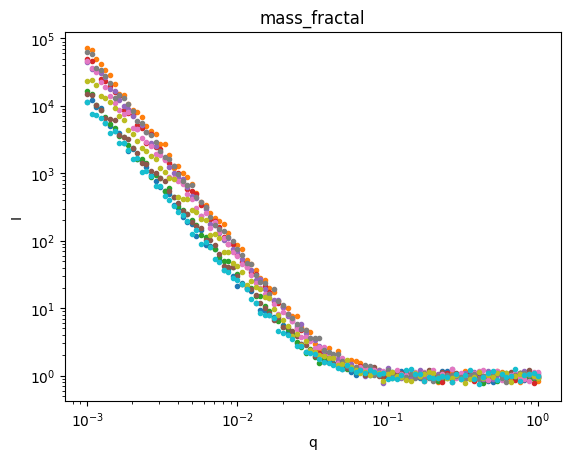

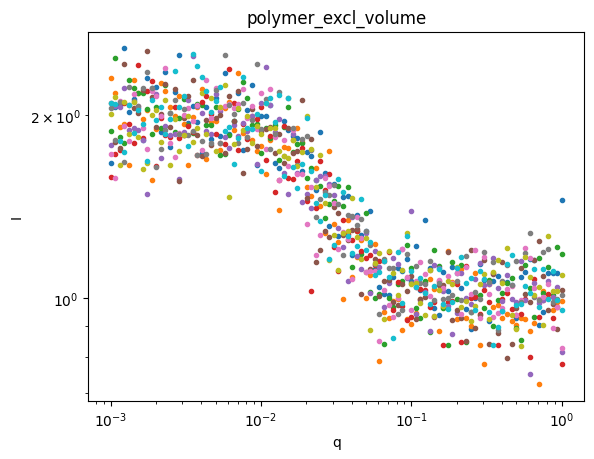

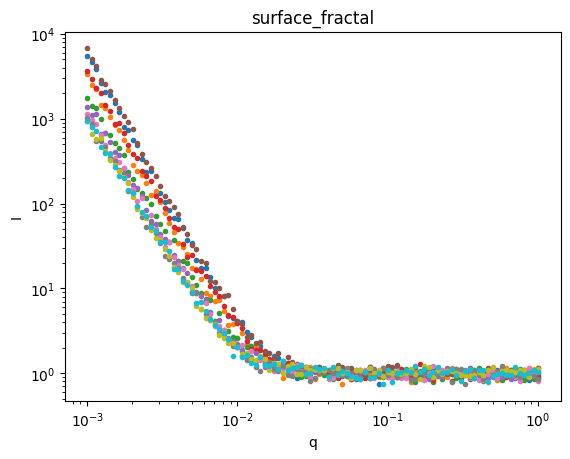

In [3]:
for model,sds in ds.groupby('model'):
    plt.figure()
    sds.I.plot.line(x='q',xscale='log',yscale='log',marker='.',ls='None',add_legend=False);
    plt.title(model)

## Defining the Fit
The first step to AutoSAS is to define which models we'd like to fit. 

In [20]:
model_inputs = [
    {
        "name": "surface_fractal", # your name for the model, can be anything
        "sasmodel": "power_law", # the name of the sasmodel in the sasmodels library
        'q_min':0.001,
        'q_max':1.0,
        "fit_params": {
            "power": {"value": 4, "bounds": (3, 4)},
            "scale": {"value": 1.0, "bounds": (1e-6,1e-3)},
            "background": {"value": 1.0},
        },
    },
    {
        "name": "mass_fractal", 
        "sasmodel": "power_law", 
        'q_min':0.001,
        'q_max':1.0,
        "fit_params": {
            "power": {"value": 4, "bounds": (1.7, 3)},
            "scale": {"value": 1.0, "bounds": (1e-4,1e-1)},
            "background": {"value": 1.0},
        },
    },
    {
        "name": "polymer", 
        "sasmodel": "polymer_excl_volume",
        'q_min':0.001,
        'q_max':1.0,
        "fit_params": {
            "scale": {"value": 1.0, "bounds": (1e-2,1e2)},
            "rg": {"value": 60.0, "bounds": (10,150)},
            "background": {"value": 1.0},
        },
    }   
]

## Building and Executing the Pipeline

In [21]:
with Pipeline() as p:
    AutoSAS(
        sas_variable='I',
        sas_err_variable='dI',
        q_variable = 'q',
        output_prefix='fit',
        model_inputs=model_inputs,
    )
p.print()

PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <AutoSAS>                           ['q', 'I', 'dI'] ---> ['fit_all_chisq']

Input Variables
---------------
0) q
1) I
2) dI

Output Variables
----------------
0) fit_all_chisq


Now we're ready to fit! 

In [22]:
ds_result = p.calculate(ds)
ds_result

  0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset> Size: 202kB
Dimensions:                    (sample: 30, q: 100, models: 3,
                                surface_fractal_params: 3,
                                mass_fractal_params: 3, polymer_params: 3,
                                fit_q_surface_fractal: 100,
                                fit_q_mass_fractal: 100, fit_q_polymer: 100)
Coordinates:
  * q                          (q) float64 800B 0.001 0.001072 ... 0.9326 1.0
  * models                     (models) <U15 180B 'surface_fractal' ... 'poly...
  * surface_fractal_params     (surface_fractal_params) <U26 312B 'surface_fr...
  * mass_fractal_params        (mass_fractal_params) <U23 276B 'mass_fractal_...
  * polymer_params             (polymer_params) <U18 216B 'polymer_scale' ......
  * fit_q_surface_fractal      (fit_q_surface_fractal) float64 800B 0.001 ......
  * fit_q_mass_fractal         (fit_q_mass_fractal) float64 800B 0.001 ... 1.0
  * fit_q_polymer              (fit_q_polymer) float64 800B 0.001 ... 1.0
Dimensions without coordinates: sample
Data variables: (12/18)
    I                          (sample, q) float64 24kB 5.465e+03 ... 1.002
    dI                         (sample, q) float64 24kB 545.9 429.3 ... 0.09923
    model                      (sample) object 240B 'surface_fractal' ... 'ma...
    sas_fit_sample             (sample) int64 240B 0 1 2 3 4 ... 25 26 27 28 29
    fit_all_chisq              (sample, models) float64 720B 1.023 ... 27.2
    probabilities              (sample, models) float64 720B 0.01182 ... 0.00...
    ...                         ...
    fit_I_surface_fractal      (sample, fit_q_surface_fractal) float64 24kB 5...
    residuals_surface_fractal  (sample, fit_q_surface_fractal) float64 24kB -...
    fit_I_mass_fractal         (sample, fit_q_mass_fractal) float64 24kB 956....
    residuals_mass_fractal     (sample, fit_q_mass_fractal) float64 24kB -8.2...
    fit_I_polymer              (sample, fit_q_polymer) float64 24kB 6.219 ......
    residuals_polymer          (sample, fit_q_polymer) float64 24kB -10.0 ......

This dataset contains

## Evaluating the Fit Results

/var/folders/hz/ncmvlr713mq6xjcnrgwxp2t4001r_z/T/ipykernel_50006/354724551.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


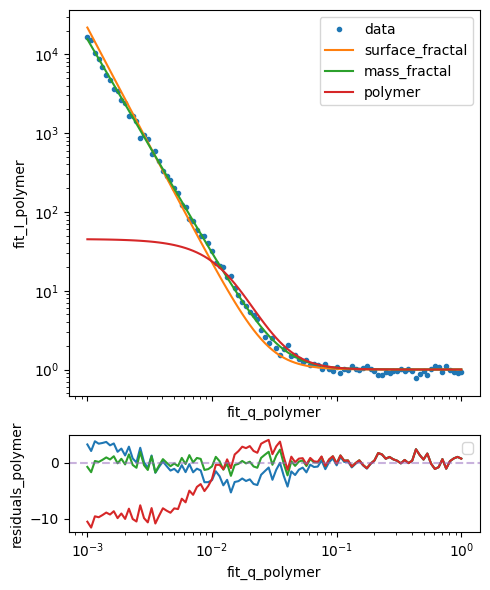

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6), height_ratios=[4, 1], sharex=True)

# Top plot - data and fits
ds_result.isel(sample=data_index).I.plot.line(x='q', xscale='log', yscale='log', marker='.', ls='None', label='data', ax=ax1)
ds_result.isel(sample=data_index).fit_I_surface_fractal.plot.line(x='fit_q_surface_fractal', xscale='log', yscale='log', label='surface_fractal', ax=ax1)
ds_result.isel(sample=data_index).fit_I_mass_fractal.plot.line(x='fit_q_mass_fractal', xscale='log', yscale='log', label='mass_fractal', ax=ax1)
ds_result.isel(sample=data_index).fit_I_polymer.plot.line(x='fit_q_polymer', xscale='log', yscale='log', label='polymer', ax=ax1)
ax1.legend()

ax1.get_lines()[0].set_color('C0')  # Keep data points as first color


# Bottom plot - residuals
ds_result.isel(sample=data_index).residuals_surface_fractal.plot(x='fit_q_surface_fractal', xscale='log',  ax=ax2)
ds_result.isel(sample=data_index).residuals_mass_fractal.plot(x='fit_q_mass_fractal', xscale='log',  ax=ax2)
ds_result.isel(sample=data_index).residuals_polymer.plot(x='fit_q_polymer', xscale='log',  ax=ax2)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax2.get_lines()[1].set_color('C2')  # Skip C1, use C2 for surface_fractal
ax2.get_lines()[2].set_color('C3')  # Use C3 for mass_fractal  
ax2.get_lines()[3].set_color('C4')  # Use C4 for polymer
ax2.legend()

plt.tight_layout()


The residuals (differences between the model and data) provide a key way to assess the quality of the fits. A good fit should show residuals that:

1. Are randomly scattered around zero
2. Have no clear systematic trends or patterns
3. Are roughly within ±2-3 standard deviations of zero

Let's plot the residuals for the first sample to assess the quality of our surface fractal fits:


## Adding Model Selection to the Pipeline

## Conclusion
 
